Why is Otani's deal cotract deversed $700M/10Y?
---
Data can tell the truth.

[src](https://towardsdatascience.com/comparing-outlier-detection-methods-956f4b097061)

In [2]:
from pybaseball import (cache, batting_stats_bref, batting_stats, 
                        playerid_reverse_lookup)
import pandas as pd

cache.enable()  # avoid unnecessary requests when re-running

MIN_PLATE_APPEARANCES = 200

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# For readability and reasonable default sort order
df_bref = batting_stats_bref(2023).query(f"PA >= {MIN_PLATE_APPEARANCES}"
                                        ).rename(columns={"Lev":"League","Tm":"Team"})
df_bref.tail(2)

,Name,Age,#days,League,Team,G,PA,AB,R,H,...,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID
680,Christian Yelich,31,171,Maj-NL,Milwaukee,146,642,558,108,157,...,0,1,15,29,3,0.281,0.374,0.450,0.824,592885
682,Masataka Yoshida,29,174,Maj-AL,Boston,140,580,537,71,155,...,0,2,20,8,0,0.289,0.338,0.445,0.783,807799


In [8]:
df_bref["League"] = \
  df_bref["League"].str.replace("Maj-","").replace("AL,NL","NL/AL"
                                                  ).astype('category')

df_fg = batting_stats(2023, qual=MIN_PLATE_APPEARANCES)

key_mapping = \
  playerid_reverse_lookup(df_bref["mlbID"].to_list(), key_type='mlbam'
                         )[["key_mlbam","key_fangraphs"]
                          ].rename(columns={"key_mlbam":"mlbID",
                                            "key_fangraphs":"IDfg"}
                                  )

df = df_fg.drop(columns="Team"
               ).merge(key_mapping, how="inner", on="IDfg"
                      ).merge(df_bref[["mlbID","League","Team"]],
                              how="inner", on="mlbID"
                             ).sort_values(["League","Team","Name"])

Gathering player lookup table. This may take a moment.


Using `OBP` and `SLP` to analyze batter performance from 2023’s Major Leage Baseball (MLB) season:

- On-base percentage (`OBP`), the rate at which a batter reaches base (by hitting, walking, or getting hit by pitch) per plate appearance
- Slugging (`SLG`), the average number of total bases per at bat

In [9]:
df[["OBP","SLG"]].describe().round(3)

,OBP,SLG
count,362.000,362.000
mean,0.320,0.415
std,0.034,0.068
min,0.234,0.227
25%,0.300,0.367
50%,0.318,0.414
75%,0.340,0.460
max,0.416,0.654


In [10]:
df[['OBP','SLG']].corr().round(3)

,OBP,SLG
OBP,1.00,0.63
SLG,0.63,1.00


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

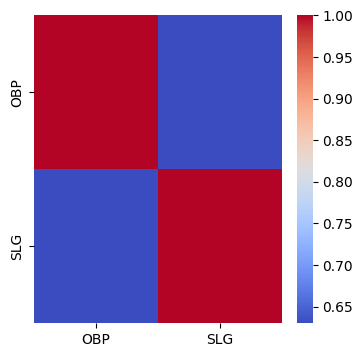

In [20]:
plt.figure(figsize=(4,4))
sns.heatmap(df[['OBP','SLG']].corr(),cmap="coolwarm");

1. Scatterplot of the players, colored by National League (NL) vs American League (AL)
2. Bivariate kernel density estimator (KDE) plot of the players, which smoothes the scatterplot with a Gaussian kernel to estimate density
3. Marginal KDE plots of each metric

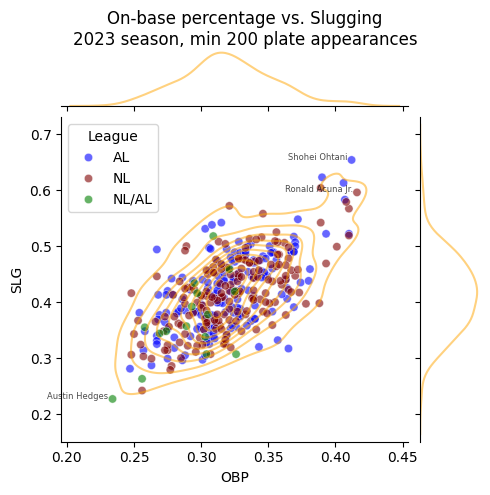

In [21]:
g = sns.JointGrid(data=df, x="OBP", y="SLG", height=5)
g = g.plot_joint(func=sns.scatterplot, data=df, hue="League",
                 palette={"AL":"blue","NL":"maroon","NL/AL":"green"},
                 alpha=0.6
                )
g.fig.suptitle("On-base percentage vs. Slugging\n2023 season, min "
               f"{MIN_PLATE_APPEARANCES} plate appearances"
              )
g.figure.subplots_adjust(top=0.9)
sns.kdeplot(x=df["OBP"], color="orange", ax=g.ax_marg_x, alpha=0.5)
sns.kdeplot(y=df["SLG"], color="orange", ax=g.ax_marg_y, alpha=0.5)
sns.kdeplot(data=df, x="OBP", y="SLG",
            ax=g.ax_joint, color="orange", alpha=0.5
           )
df_extremes = df[ df["OBP"].isin([df["OBP"].min(),df["OBP"].max()]) 
                 | df["OPS"].isin([df["OPS"].min(),df["OPS"].max()])
                ]

for _,row in df_extremes.iterrows():
    g.ax_joint.annotate(row["Name"], (row["OBP"], row["SLG"]),size=6,
                      xycoords='data', xytext=(-3, 0),
                        textcoords='offset points', ha="right",
                      alpha=0.7)
plt.show()

In [22]:
import numpy as np

X = df[["OBP","SLG"]].to_numpy()

GRID_RESOLUTION = 200

disp_x_range, disp_y_range = ( (.6*X[:,i].min(), 1.2*X[:,i].max()) 
                               for i in [0,1]
                             )
xx, yy = np.meshgrid(np.linspace(*disp_x_range, GRID_RESOLUTION), 
                     np.linspace(*disp_y_range, GRID_RESOLUTION)
                    )
grid_shape = xx.shape
grid_unstacked = np.c_[xx.ravel(), yy.ravel()]

Outlier Detection
---
1. Elliptic Envelope, for low dimesional data, each feature data were Gaussian distributed, i.e. normal distributed; 
2. local Outlier Factor,  Observations with much lower density than their neighbors are considered outliers;
3. SVM, typycal algorithm in Machine Learning, ignored here.
4. Isolation Forest, tree-based algorithm, outliers are more quickly isolated by random splits than inliers.

In [10]:
from sklearn.covariance import EllipticEnvelope

ell = EllipticEnvelope(random_state=17).fit(X)
df["outlier_score_ell"] = ell.decision_function(X)
Z_ell = ell.decision_function(grid_unstacked).reshape(grid_shape)

In [11]:
K = int(np.sqrt(X.shape[0]))

print(f"Using K={K} nearest neighbors.")

Using K=19 nearest neighbors.


In [12]:
from scipy.spatial.distance import pdist, squareform

# If we didn't have the elliptical envelope already,
# we could calculate robust covariance:
#   from sklearn.covariance import MinCovDet
#   robust_cov = MinCovDet().fit(X).covariance_
# But we can just re-use it from elliptical envelope:
robust_cov = ell.covariance_

print(f"Robust covariance matrix:\n{np.round(robust_cov,5)}\n")

inv_robust_cov = np.linalg.inv(robust_cov)

D_mahal = squareform(pdist(X, 'mahalanobis', VI=inv_robust_cov))

print(f"Mahalanobis distance matrix of size {D_mahal.shape}, "
      f"e.g.:\n{np.round(D_mahal[:5,:5],3)}...\n...\n")

Robust covariance matrix:
[[0.00077 0.00095]
 [0.00095 0.00366]]

Mahalanobis distance matrix of size (362, 362), e.g.:
[[0.    2.86  1.278 0.964 0.331]
 [2.86  0.    2.63  2.245 2.813]
 [1.278 2.63  0.    0.561 0.956]
 [0.964 2.245 0.561 0.    0.723]
 [0.331 2.813 0.956 0.723 0.   ]]...
...



In [13]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=K, metric="precomputed", novelty=True
                        ).fit(D_mahal)

df["outlier_score_lof"] = lof.negative_outlier_factor_

In [14]:
from scipy.spatial.distance import cdist

D_mahal_grid = cdist(XA=grid_unstacked, XB=X, 
                     metric='mahalanobis', VI=inv_robust_cov
                    )
Z_lof = lof.decision_function(D_mahal_grid).reshape(grid_shape)

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

suv = make_pipeline(
            RobustScaler(),
            Nystroem(random_state=17),
            SGDOneClassSVM(random_state=17)
).fit(X)

df["outlier_score_svm"] = suv.decision_function(X)

Z_svm = suv.decision_function(grid_unstacked).reshape(grid_shape)

In [16]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=17).fit(X)

df["outlier_score_iso"] = iso.score_samples(X)

Z_iso = iso.decision_function(grid_unstacked).reshape(grid_shape)

In [20]:
from adjustText import adjust_text
from sklearn.preprocessing import QuantileTransformer

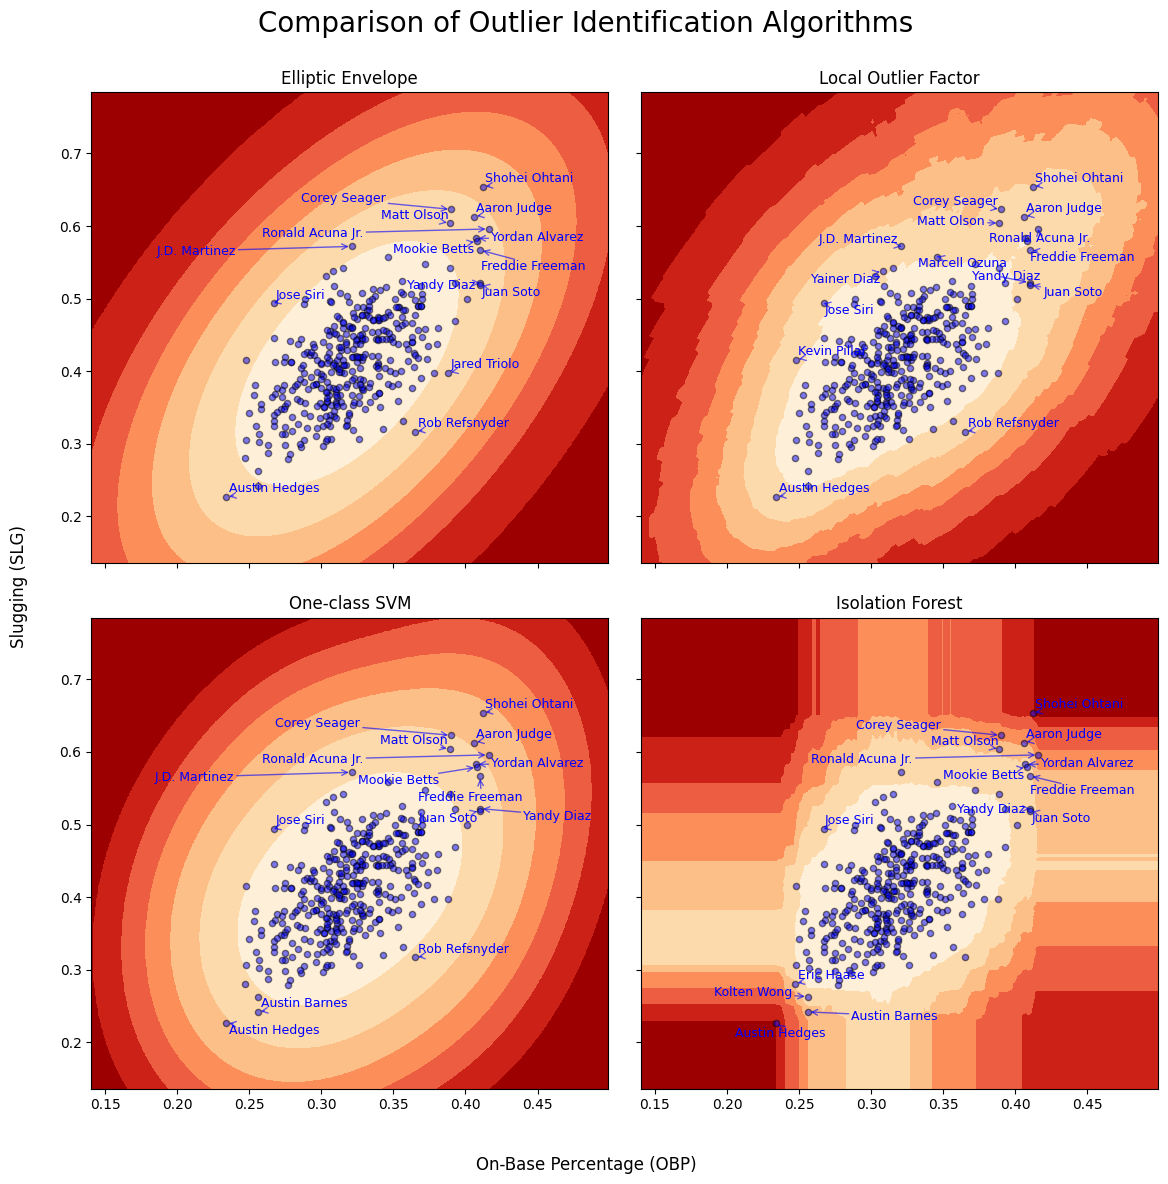

Counting down to the greatest outlier...

            Name  AB  PA   H  2B  3B  HR  BB  HBP  SO   OBP  Pctl_OBP   SLG  Pctl_SLG  Rank_ELL  Rank_ISO  Rank_LOF  Rank_SVM
   Austin Barnes 178 200  32   5   0   2  17    2  43 0.256       2.6 0.242       0.6        19         7        25        12
   J.D. Martinez 432 479 117  27   2  33  34    2 149 0.321      52.8 0.572      98.1        15        18         5        15
      Yandy Diaz 525 600 173  35   0  22  65    8  94 0.410      99.2 0.522      95.4        13        15        13        10
       Jose Siri 338 364  75  13   2  25  20    2 130 0.267       5.5 0.494      88.4         8        14        15        13
       Juan Soto 568 708 156  32   1  35 132    2 129 0.410      99.2 0.519      95.0        12        13        11        11
    Mookie Betts 584 693 179  40   1  39  96    8 107 0.408      98.6 0.579      98.3         7        10        20         7
   Rob Refsnyder 202 243  50   9   1   1  33    5  47 0.365      90.5 0.317 

In [21]:
N_QUANTILES = 8 # This many color breaks per chart
N_CALLOUTS=15  # Label this many top outliers per chart

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

fig.suptitle("Comparison of Outlier Identification Algorithms",size=20)
fig.supxlabel("On-Base Percentage (OBP)")
fig.supylabel("Slugging (SLG)")

ax_ell = axs[0,0]
ax_lof = axs[0,1]
ax_svm = axs[1,0]
ax_iso = axs[1,1]

model_abbrs = ["ell","iso","lof","svm"]

qt = QuantileTransformer(n_quantiles=N_QUANTILES)

for ax, nm, abbr, zz in zip( [ax_ell,ax_iso,ax_lof,ax_svm], 
                            ["Elliptic Envelope","Isolation Forest",
                             "Local Outlier Factor","One-class SVM"], 
                            model_abbrs,
                            [Z_ell,Z_iso,Z_lof,Z_svm]
                           ):
    ax.title.set_text(nm)
    outlier_score_var_nm = f"outlier_score_{abbr}"
    
    qt.fit(np.sort(zz.reshape(-1,1)))
    zz_qtl = qt.transform(zz.reshape(-1,1)).reshape(zz.shape)

    cs = ax.contourf(xx, yy, zz_qtl, cmap=plt.cm.OrRd.reversed(), 
                     levels=np.linspace(0,1,N_QUANTILES)
                    )
    ax.scatter(X[:, 0], X[:, 1], s=20, c="b", edgecolor="k", alpha=0.5)
    
    df_callouts = df.sort_values(outlier_score_var_nm).head(N_CALLOUTS)
    texts = [ ax.text(row["OBP"], row["SLG"], row["Name"], c="b",
                      size=9, alpha=1.0) 
             for _,row in df_callouts.iterrows()
            ]
    adjust_text(texts, 
                df_callouts["OBP"].values, df_callouts["SLG"].values, 
                arrowprops=dict(arrowstyle='->', color="b", alpha=0.6), 
                ax=ax
               )

plt.tight_layout(pad=2)
plt.show()

for var in ["OBP","SLG"]:
    df[f"Pctl_{var}"] = 100*(df[var].rank()/df[var].size).round(3)

model_score_vars = [f"outlier_score_{nm}" for nm in model_abbrs]  
model_rank_vars = [f"Rank_{nm.upper()}" for nm in model_abbrs]


df[model_rank_vars] = df[model_score_vars].rank(axis=0).astype(int)
    
# Averaging the ranks is arbitrary; we just need a countdown order
df["Rank_avg"] = df[model_rank_vars].mean(axis=1)

print("Counting down to the greatest outlier...\n")
print(
    df.sort_values("Rank_avg",ascending=False
                  ).tail(N_CALLOUTS)[["Name","AB","PA","H","2B","3B",
                                      "HR","BB","HBP","SO","OBP",
                                      "Pctl_OBP","SLG","Pctl_SLG"
                                     ] + 
                             [f"Rank_{nm.upper()}" for nm in model_abbrs]
                            ].to_string(index=False)
)

Conclusion
---
Almost the same:
1. Elliptic Envelope, output has the narrower contours in the minor axis such that highlight some potential players who run contrary to the overall correlation between features. For example, Rays outfielder José Siri had high SLG (`88`th percentile), 長打率, versus low OBP (`5`th percentile), 上壘率. `Advantages`: easy to use without configuration, and it provides the robust covariance matrix; suitable for the low-dimensional data, and for nomalized data. 
2. One-class SVM, has more uniformly spaced contours, so it tends to emphasize observations along the overall direction of correlation, for instance All-Star first basemen Freddie Freeman (Dodgers), SLG+OBP: 0.99+0.97, and Yandy Diaz (Rays), SLG+OBP: 0.99+0.95.
3. LOF was the most time-consuming to implement since we created robust distance matrices for fitting and scoring and requires paramter tuning, `k`.
4. Isolation Forest tends to emphasize observations at the corners of the feature space; Austin Hedges, who played for the Pirates and Rangers in 2023 and signed with Guardians for 2024, is strong defensively but the worst batter (with at least 200 plate appearances) in both SLG and OBP; thia make him being number 1 in the method, but not Otani. However, any single one OBP or SLG should be changes the position.

Finally, Otani deserved for the $700 m for 10Y contract since three one's and one second. in the outlier dections!